# ***PART 1 : Category Classificataion***

In [1]:
import pandas as pd
import huggingface_hub
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### *Reading train.csv file*

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")

Mounted at /content/drive


In [4]:
train = pd.read_csv("assignment5/train.csv")
train

,text,label
0,"U.S. Strikes Zarqawi Network, Killing 15 BAGHD...",0
1,MGM shares jump 7.5 pct; report suggests deal ...,2
2,Logitech launches laser-tracking mouse SAN FRA...,3
3,Orb Unveils New Service for Digital Media (AP)...,3
4,"Norwegian police hunt for motive, robbers in M...",0
...,...,...
29995,Two Apes Arrive at Education Center (AP) AP - ...,3
29996,Japan Greets U.S. Army Deserter Jenkins (AP) A...,0
29997,Supreme Court Debates Teenage Executions WASHI...,0
29998,"Stocks End Flat, Microsoft Lifts Techs NEW YO...",2


### *Data Exploring*

Shape of train dataset: (30000, 2)
Labels: [0, 1, 2, 3]
Distributions of labels label
0    7500
2    7500
3    7500
1    7500
Name: count, dtype: int64


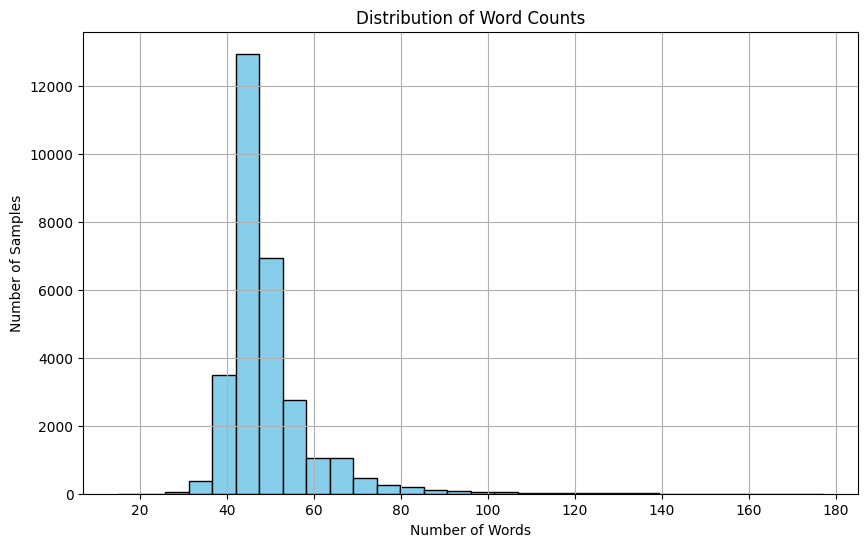

Longest: 177 words
Shortest: 15 words


In [ ]:
print("Shape of train dataset:", train.shape)
print("Labels:", sorted([int(label) for label in train["label"].unique()]))
print("Distributions of labels",train["label"].value_counts())
for idx in range(len(train)):
    train.loc[idx,"word amount"] = len(train.loc[idx,"text"].split())

plt.figure(figsize=(10, 6))
plt.hist(train["word amount"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

print("Longest:",int(max(train["word amount"])),"words")
print("Shortest:",int(min(train["word amount"])),"words")

### Initial Data Exploration

- **Class Distribution**:  
  The dataset is well-balanced, with each of the four classes containing exactly **7,500 samples**.

- **Text Length**:  
  - Most texts fall within the **40 to 60 words** range.  
  - The **shortest text** contains **15 words**, and the **longest text** has **177 words**.



In [ ]:
train.describe()

,label,word amount
count,30000.000000,30000.000000
mean,1.500000,49.099733
std,1.118053,10.475755
min,0.000000,15.000000
25%,0.750000,43.000000
50%,1.500000,47.000000
75%,2.250000,51.000000
max,3.000000,177.000000


### *Removing stopwords*

In [5]:
def clean_text(text):
    text = str(text).lower()
    words = word_tokenize(text)

    cleaned = [
        word for word in words
        if word.lower() not in stop_words and word not in string.punctuation
    ]

    return ' '.join(cleaned)

for idx in range(len(train)):
    train.loc[idx,"text"] = clean_text(train.loc[idx,"text"])
train

,text,label
0,u.s. strikes zarqawi network killing 15 baghda...,0
1,mgm shares jump 7.5 pct report suggests deal n...,2
2,logitech launches laser-tracking mouse san fra...,3
3,orb unveils new service digital media ap ap mo...,3
4,norwegian police hunt motive robbers munch art...,0
...,...,...
29995,two apes arrive education center ap ap warning...,3
29996,japan greets u.s. army deserter jenkins ap ap ...,0
29997,supreme court debates teenage executions washi...,0
29998,stocks end flat microsoft lifts techs new york...,2


This function first converts the input text to lowercase and tokenizes it into individual words. It then filters out stopwords and punctuation, retaining only meaningful tokens. Finally, it joins the cleaned tokens back into a single string.

### *Data exploring after preprocess*

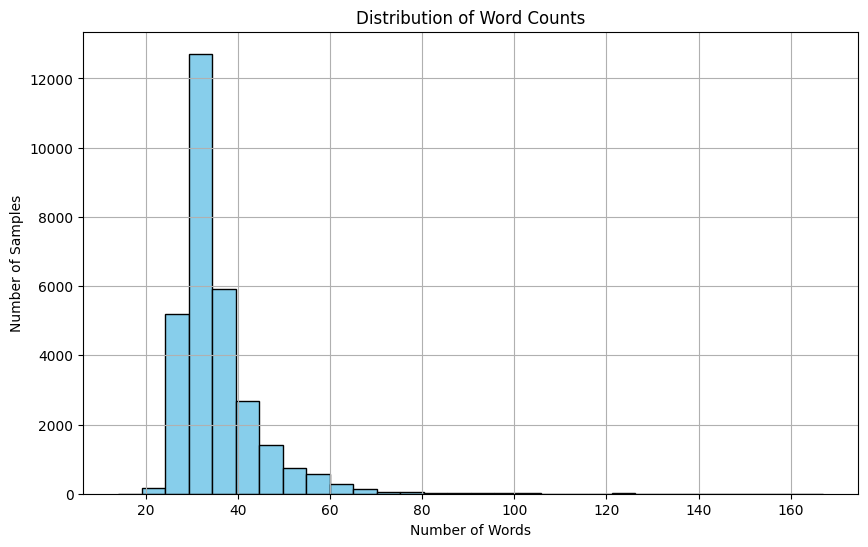

Longest: 167 words
Shortest: 14 words


In [ ]:
for idx in range(len(train)):
    train.loc[idx,"word amount"] = len(train.loc[idx,"text"].split())

plt.figure(figsize=(10, 6))
plt.hist(train["word amount"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

print("Longest:",int(max(train["word amount"])),"words")
print("Shortest:",int(min(train["word amount"])),"words")

###  After Preprocess Part(Removing stopwords and punctuations):
  - Most texts fall within the **25 to 45 words** range.  
  - The **shortest text** contains **14 words**, and the **longest text** has **167 words**.


### *Defining Custom Dataset*

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = NewsDataset(train["text"].tolist(), train["label"].tolist(), tokenizer, 256)


### Custom Dataset for News Classification

To prepare our text data for training with a BERT-based model, we define a custom `NewsDataset` class that inherits from `torch.utils.data.Dataset`. This class helps us preprocess and organize the data in a format suitable for PyTorch models.

- **Initialization (`__init__`)**:  
  The class takes a list of texts, corresponding labels, a pretrained tokenizer (e.g., BERT tokenizer), and a maximum sequence length. These are stored as attributes for later use.

- **Length Method (`__len__`)**:  
  Returns the total number of samples in the dataset. This allows PyTorch’s `DataLoader` to know how many batches to create.

- **Get Item Method (`__getitem__`)**:  
  For a given index:
  - Retrieves the text and applies the tokenizer with truncation and padding up to `max_len`.
  - The tokenizer outputs are tensors with an extra batch dimension, which are squeezed to get the correct shape.
  - The corresponding label is also converted to a tensor and added to the output dictionary.
  - Returns a dictionary containing tokenized input IDs, attention masks, and labels.

Finally, we instantiate the dataset using the `NewsDataset` class by passing in the cleaned training texts, their labels, the pretrained BERT tokenizer (`bert-base-uncased`), and a maximum sequence length of 256 tokens.


### ***Training BERT Model***

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train-Validation Split and DataLoader Creation

In this section, the dataset is split into training and validation sets, and `DataLoader` objects are created for efficient batch processing. Then, a pre-trained BERT model is initialized for sequence classification.

- **Dataset Splitting**:
  - `random_split()` is used to divide the dataset into **90% training** and **10% validation** subsets.
  - `train_size` and `val_size` are computed dynamically based on the dataset length.

- **DataLoader**:
  - `train_loader` is created with `shuffle=True` to ensure the training data is shuffled at each epoch, which improves generalization.
  - `val_loader` does not shuffle the data, since evaluation does not require randomness.

- **Device Configuration**:
  - Checks if a GPU is available using `torch.cuda.is_available()`. If available, the model runs on CUDA; otherwise, it falls back to CPU.

- **Model Initialization**:
  - A pre-trained `BertForSequenceClassification` model from Hugging Face’s `transformers` library is loaded.
  - The model is configured with `num_labels=4` to match the number of output classes in the classification task.
  - Finally, the model is moved to the selected device GPU.


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2,
    threshold=1e-5, verbose=True
)

for epoch in range(10):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/10", leave=False)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

        current_lr = optimizer.param_groups[0]['lr']

        loop.set_postfix(loss=loss.item(), lr=current_lr)

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f} - Learning Rate: {current_lr}")

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

    lr_scheduler.step(avg_val_loss)

    model.save_pretrained("model_saved")
    tokenizer.save_pretrained("model_saved")


Epoch 1 - Training Loss: 0.2592 - Learning Rate: 5e-05
Epoch 1 - Validation Loss: 0.1681 - Validation Accuracy: 0.9457


Epoch 2 - Training Loss: 0.1343 - Learning Rate: 5e-05
Epoch 2 - Validation Loss: 0.1874 - Validation Accuracy: 0.9413


Epoch 3 - Training Loss: 0.0899 - Learning Rate: 5e-05
Epoch 3 - Validation Loss: 0.1660 - Validation Accuracy: 0.9470


Epoch 4 - Training Loss: 0.0572 - Learning Rate: 5e-05
Epoch 4 - Validation Loss: 0.2231 - Validation Accuracy: 0.9420


Epoch 5 - Training Loss: 0.0456 - Learning Rate: 5e-05
Epoch 5 - Validation Loss: 0.2320 - Validation Accuracy: 0.9430


KeyboardInterrupt: 

### Training & Evaluation Loop

- Trains the BERT model for 10 epochs using `AdamW` optimizer (`lr=5e-5`).
- Applies `ReduceLROnPlateau` to reduce the learning rate if validation loss doesn't improve.
- After each batch, logs the current loss and learning rate.
- At the end of each epoch:
  - Prints average training loss and current learning rate.
  - Evaluates on the validation set and prints loss & accuracy.
  - Saves the model and tokenizer to `model_saved/`.
- Since the model started to overfit after the 5th epoch, I decided to stop training at that point.


### ***Testing Trained Model***

In [6]:
test = pd.read_csv("test.csv")
test

,text,label
0,Fan v Fan: Manchester City-Tottenham Hotspur T...,1
1,Paris Tourists Search for Key to 'Da Vinci Cod...,0
2,Net firms: Don't tax VoIP The Spanish-American...,3
3,Dependent species risk extinction The global e...,3
4,EDS Is Charter Member of Siebel BPO Alliance (...,3
...,...,...
7595,"Dutch security reviewed on threat THE HAGUE, N...",0
7596,"Inheriting Aura From Woods, the New King of Go...",1
7597,Bluetooth Group Outlines Strategy (NewsFactor)...,3
7598,SEVEN KILLED IN KABUL BLOODSHED At least seven...,0


In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def test_model(df, model, tokenizer, batch_size=16, max_length=256, class_names=["0","1","2","3"]):
    for idx in range(len(df)):
        df.loc[idx,"text"] = clean_text(df.loc[idx,"text"])

    encodings = tokenizer(
        df["text"].tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    labels = torch.tensor(df["label"].tolist())

    dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"], labels)
    test_loader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Test Accuracy: {accuracy:.4f} - Test F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


###  Model Testing and Evaluation

- **Text Preprocessing:** Cleans and lowercases all test texts using `clean_text`.
- **Tokenization:** Applies BERT tokenizer with padding and truncation to a fixed `max_length`.
- **Test Loader:** Converts data into a `TensorDataset` and uses `DataLoader` for batching.
- **Inference:** Runs model in evaluation mode and collects predictions.
- **Metrics:** Calculates overall accuracy and macro F1 score.
- **Visualization:** Plots a confusion matrix using `seaborn` to visualize class-wise performance.


In [11]:
model = BertForSequenceClassification.from_pretrained("model_saved")
tokenizer = BertTokenizer.from_pretrained("model_saved")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Test Accuracy: 0.9217 - Test F1 Score: 0.9216


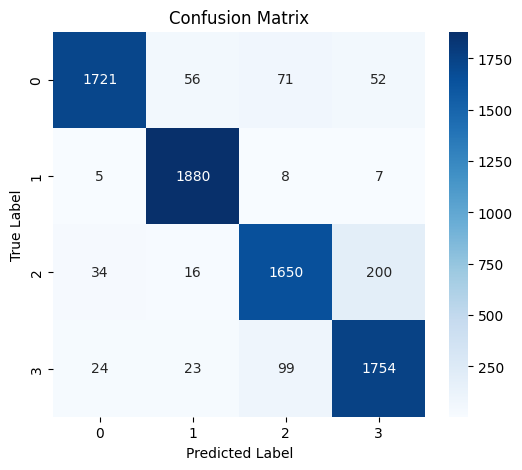

In [ ]:
test_model(test,model,tokenizer)

In [12]:
import torch
import pandas as pd

def predict_first_5(df, model, tokenizer, device, max_length=256):
    df["text"] = df["text"].apply(clean_text)
    df_5 = df.head(5)

    encodings = tokenizer(
        df_5["text"].tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

    preds = preds.cpu().numpy()
    truths = df_5["label"].tolist()

    for i in range(5):
        print(f"Text: {df.iloc[i]['text']}...")
        print(f"True Label: {truths[i]} - Predicted Label: {preds[i]}\n")
predict_first_5(test, model, tokenizer, device)


Text: fan v fan manchester city-tottenham hotspur weekend manchester city entertain spurs last seasons seven-goal fa cup epic two teams still fresh memory entertain could operative word...
True Label: 1 - Predicted Label: 1

Text: paris tourists search key 'da vinci code reuters reuters funny thing happened way the\mona lisa visitors louvre museum paris home the\world 's famous painting started quizzing tour guides\about dan brown 's best-selling novel `` da vinci code ''...
True Label: 0 - Predicted Label: 3

Text: net firms n't tax voip spanish-american war `` temporary '' tax created pay extended internet phone calls industry groups tell irs...
True Label: 3 - Predicted Label: 2

Text: dependent species risk extinction global extinction crisis worse thought thousands quot affiliated quot species also risk figure calculations...
True Label: 3 - Predicted Label: 3

Text: eds charter member siebel bpo alliance newsfactor newsfactor siebel systems nasdaq sebl named eds charter partner s

# ***PART2 : Title and Well-Written Article Generation***

In [ ]:
from google import genai
import re

def create_article(text):
  client = genai.Client(api_key="%%API KEY%%")
  response = client.models.generate_content(
      model="gemini-2.0-flash",
      contents=f"""
      {text}
      Create or extract professional title about the text above.
      Write an article about the text above. The article MUST be well written, suitable for publish.
      Your output must be in this format: <Title> Title Content </Title>  <Article> Article Content </Article>
      """,
  )
  title = re.search(r"<Title>(.*?)</Title>", response.text.strip(),re.DOTALL).group(1)
  article = re.search(r"<Article>(.*?)</Article>", response.text.strip(),re.DOTALL).group(1)
  return title, article

###  Article Generation with Gemini API

This function `create_article` takes a text input and uses Google's Gemini model (`gemini-2.0-flash`) to generate a professional article and a suitable title. Here's how it works:

- **Input**: Raw text string.
- **API Request**: Sends the text to the Gemini model using `generate_content`, asking it to return both a title and an article in a specific XML-like format.
- **Response Parsing**: The response is parsed using regular expressions to extract the title and article from the `<Title>...</Title>` and `<Article>...</Article>` tags.
- **Output**: Returns the generated `title` and `article` as strings.

This function automates the creation of publishable content from raw input text using generative AI.


# **PART 3**

In [ ]:
test = pd.read_csv("test.csv")
test

,text,label
0,Fan v Fan: Manchester City-Tottenham Hotspur T...,1
1,Paris Tourists Search for Key to 'Da Vinci Cod...,0
2,Net firms: Don't tax VoIP The Spanish-American...,3
3,Dependent species risk extinction The global e...,3
4,EDS Is Charter Member of Siebel BPO Alliance (...,3
...,...,...
7595,"Dutch security reviewed on threat THE HAGUE, N...",0
7596,"Inheriting Aura From Woods, the New King of Go...",1
7597,Bluetooth Group Outlines Strategy (NewsFactor)...,3
7598,SEVEN KILLED IN KABUL BLOODSHED At least seven...,0


In [ ]:
model = BertForSequenceClassification.from_pretrained("model_saved")
tokenizer = BertTokenizer.from_pretrained("model_saved")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cleaned_article = clean_text(test.loc[1,"text"])

classes = {0:"World",1:"Sports",2:"Business",3:"Sci/Tech"}
inputs = tokenizer(
    cleaned_article,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=256
)

inputs = {k: v.to(device) for k, v in inputs.items()}


model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    predicted_category = classes[predicted_class]
title, article = create_article(cleaned_article)
result = {
    "category": predicted_category,
    "title": title,
    "article": article
}

###  Predicting News Category and Generating an Article

This code performs two key tasks on a given news article:

1. **Text Classification using a Fine-Tuned BERT Model**  
   - The model and tokenizer are loaded from the previously saved checkpoint (`model_saved`).
   - The input text (`test.loc[1, "text"]`) is cleaned using the `clean_text` function.
   - The cleaned text is tokenized and moved to the appropriate device (CPU or GPU).
   - The model runs in evaluation mode (`model.eval()`), and the most likely category is predicted using `argmax` on the logits.
   - A class dictionary maps prediction indices to human-readable categories such as `"World"`, `"Sports"`, `"Business"`, and `"Sci/Tech"`.

2. **Content Generation using Gemini API**  
   - The `create_article` function sends the cleaned text to a generative AI model (Gemini) to:
     - Extract or generate a professional title.
     - Create a well-structured article based on the input text.
   - The output includes a title and full article in predefined XML-like tags (`<Title>...</Title>` and `<Article>...</Article>`).

Finally, the results are compiled into a dictionary containing:
- The predicted category,
- The generated title, and
- The AI-written article.


In [ ]:
result

{'category': 'Sci/Tech',
 'title': "Da Vinci Code's Enduring Mystery: Tourists Quiz Louvre Guides",
 'article': '\n\n**Da Vinci Code\'s Enduring Mystery: Tourists Quiz Louvre Guides**\n\nParis – The echoes of Dan Brown\'s "The Da Vinci Code" continue to resonate within the hallowed halls of the Louvre Museum in Paris. Despite the novel\'s publication years ago, and its subsequent film adaptation, visitors from around the world, eager to experience the home of the Mona Lisa and other artistic masterpieces, are still peppering tour guides with questions inspired by Brown\'s best-selling thriller.\n\nReuters reports that tourists are actively seeking information connecting Leonardo da Vinci\'s art and alleged secret societies, mirroring the conspiracy theories woven throughout the book. "A funny thing happened on the way to the Mona Lisa," one might say, as visitors bypass straightforward art historical analyses to delve into the narrative\'s intricate web of symbols and hidden meanings.\

# ***FINAL TESTS AND LAST 5 SAMPLES OF TRAİN.CSV***

No need extra preprocess step because train datapoints are preprocessed before training phase.

In [ ]:
train

,text,label,word amount
0,u.s. strikes zarqawi network killing 15 baghda...,0,37.0
1,mgm shares jump 7.5 pct report suggests deal n...,2,31.0
2,logitech launches laser-tracking mouse san fra...,3,41.0
3,orb unveils new service digital media ap ap mo...,3,35.0
4,norwegian police hunt motive robbers munch art...,0,33.0
...,...,...,...
29995,two apes arrive education center ap ap warning...,3,31.0
29996,japan greets u.s. army deserter jenkins ap ap ...,0,38.0
29997,supreme court debates teenage executions washi...,0,37.0
29998,stocks end flat microsoft lifts techs new york...,2,47.0


In [ ]:
final_list = []
classes = {0:"World",1:"Sports",2:"Business",3:"Sci/Tech"}
for idx in range(1,5):
  inputs = tokenizer(
    train.loc[len(train)-idx,"text"],
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=256
  )

  inputs = {k: v.to(device) for k, v in inputs.items()}


  model.eval()
  with torch.no_grad():
      outputs = model(**inputs)
      predicted_class = torch.argmax(outputs.logits, dim=1).item()
      predicted_category = classes[predicted_class]
  title, article = create_article(train.loc[len(train)-idx,"text"])
  final_dict = {
      "category": predicted_category,
      "title": title,
      "article": article
  }
  final_list.append(final_dict)

In [ ]:
final_list

[{'category': 'Sci/Tech',
  'title': "Oracle's Peoplesoft Acquisition Faces Antitrust Hurdle: Justice Department Intervention Looms",
  'article': "\nOracle Corporation's proposed acquisition of Peoplesoft Inc. is facing a major antitrust fight, according to a report in *The Washington Post*. The Justice Department's intervention last week suggests that the deal is far from a foregone conclusion, despite Oracle's efforts. The legal challenge signals a potential roadblock in Oracle's path to acquiring its rival, Peoplesoft, raising concerns about market competition and the implications for customers. The Justice Department's move suggests that it believes the acquisition could lead to reduced innovation and higher prices in the enterprise software market. The outcome of this antitrust battle will have significant ramifications for the future landscape of the industry.\n"},
 {'category': 'Business',
  'title': 'Stocks End Flat as Microsoft Lifts Techs; Lower Oil Prices Weigh on Energy',
